# Session 2 : Using the sliding window technique to predict on larger images

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

In this session we will load our previously detected model and apply it on large images using the sliding window technique.

The sliding window technique is a method to convert a classifier into detector. It can be illustrated by a single gif:

![sw](https://storage.googleapis.com/fchouteau-isae-deep-learning/static/sliding_window.gif)

For more information about the sliding window technique refer to this excellent article:

https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

*Note:* We are training our model to recognize images at a single scale. Satellite imagery more or less prevents the foreground/background effect that sometimes require large changes in scale between training and testing for "normal" photography. So you can ignore the bits about the image pyramid on this issue (it is very good for general culture though, and can be applied in other use cases, or if we used multiscale training to "zoom" small aircrafts for example)

In [1]:
# Put your imports here
import random

import cv2
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms

In [2]:
# Global variables
tiles_dataset_url = "https://storage.googleapis.com/fchouteau-isae-deep-learning/tiles_aircraft_dataset_2023.npz"

## Download the dataset

In [3]:
# Download data
ds = np.lib.npyio.DataSource("/tmp/")
f = ds.open(tiles_dataset_url, "rb")
eval_tiles = np.load(f)
eval_tiles = eval_tiles["eval_tiles"]

## Data Exploration

- Plot some of the images
- The images are not labelled to prevent any "competition", the objective is just to apply it.

In [4]:
eval_tiles.shape

(43, 512, 512, 3)

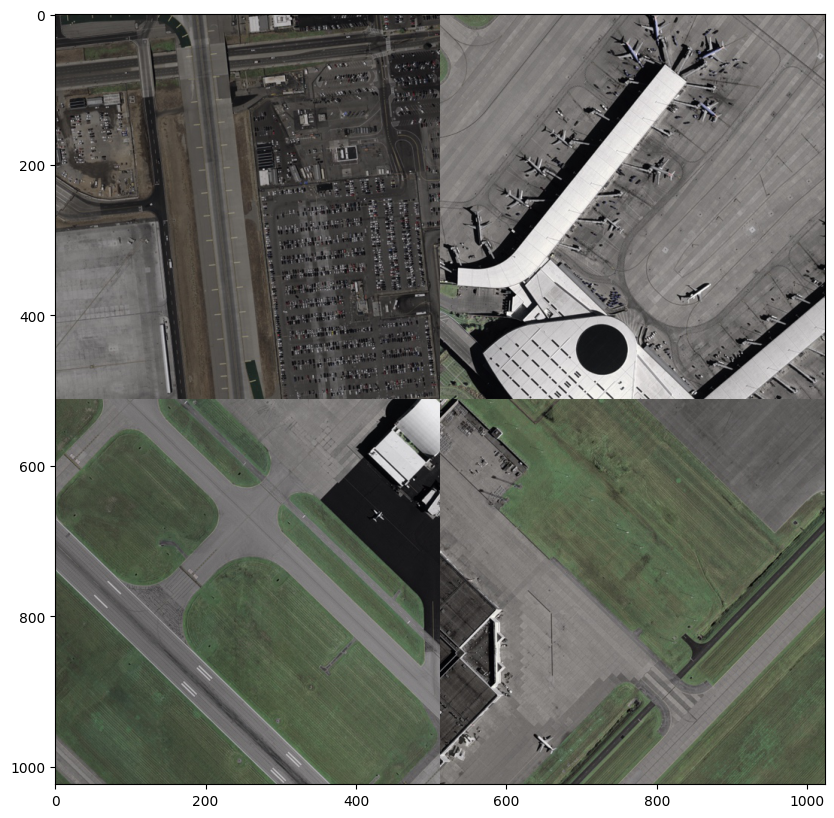

In [9]:
grid_size = 2
grid = np.zeros((grid_size * 512, grid_size * 512, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        tile = np.copy(eval_tiles[np.random.randint(0, eval_tiles.shape[0])])
        grid[i * 512 : (i + 1) * 512, j * 512 : (j + 1) * 512, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

## Reload your model

- Using the routines detailed in the previous notebook, upload the scripted model corresponding to the best training (don't forget to save it on the other notebooks) then reload the model

- Find the mean / std of the dataset you trained with to normalize the images !

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print(
        'User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])
        )
    )

Saving scripted_model.pt to scripted_model.pt
User uploaded file "scripted_model.pt" with length 1306504 bytes


In [48]:
import torch.jit

MODEL = torch.jit.load("scripted_model.pt", map_location="cpu")
MODEL = MODEL.cpu().eval()

In [50]:
MEAN = np.mean(eval_tiles, axis=(0, 1, 2)) / 255.0

STD = np.std(eval_tiles, axis=(0, 1, 2)) / 255.0

image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
    ]
)

## Implement the sliding window

Intuitively, it's about applying an aircraft classifier trained on 64x64 pictures of aircraft or "anything else" as a detector.

Our network structure more or less prevents applying it to the full 512x512 images, and even if it could (you may be able to do it with global pooling layers...) this would not bring much information ("there is at least one aircraft in this region" sometimes is not sufficient).

So the idea is to "slide" our 64x64 classifier on the image and collect the coordinates where "aircraft" is returned. Those should be the locations of our aircrafts;

You could view your model as a big convolution returning "aircraft / not aircraft". Its kernel size is 64x64, there are one or two filters depending on if you coded with softmax or crossentropy. You then just have to decide on the stride of this convolution... And to keep in mind how to go back to coordinates to plot your aircrafts afterwards ;)

There are a lot of degrees of freedom when developping sliding windows. A sliding window with a too small "step" will only provide noisy overlapping detections. A step too large will make you miss some objects.

It's up to you to find acceptable parameters.

*Note*: The dataset labels were generated so that an image is considered an aircraft **if and only if the center of an aircraft lies in the center 32x32** of the 64x64 image

In [57]:
def apply_model_on_large_image(
    img: np.ndarray, model: nn.Module, patch_size=64, patch_stride=32
):
    h, w, c = img.shape
    coords = []

    for i0 in range(0, h - patch_size + 1, patch_stride):
        for j0 in range(0, w - patch_size + 1, patch_stride):
            patch = img[i0 : i0 + patch_size, j0 : j0 + patch_size]
            patch = image_transforms(patch).unsqueeze(0)

            with torch.no_grad():
                y_pred = model(patch)
                y_pred = y_pred[0, 0].cpu().numpy()
                if y_pred > 0.75:
                    coords.append((i0 + 32, j0 + 32))
    return coords


## Apply the sliding window on the dataset and visualize results

In [33]:
k = np.random.randint(eval_tiles.shape[0])
image = np.copy(eval_tiles[k])

In [34]:
results = apply_model_on_large_image(image, MODEL)

In [46]:
def plot_results_on_image(image: np.ndarray, results):
    color = (0, 255, 0)

    image0 = np.copy(image)

    for ic, jc in results:
        image = cv2.rectangle(
            image, (jc - 32, ic - 32), (jc + 32, ic + 32), color, thickness=2
        )
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    ax[0].imshow(image0)
    ax[1].imshow(image)
    print(results)
    plt.show()

[(32, 384), (256, 480), (288, 320), (288, 352), (288, 480), (320, 96), (320, 480), (352, 64), (352, 320), (448, 448)]


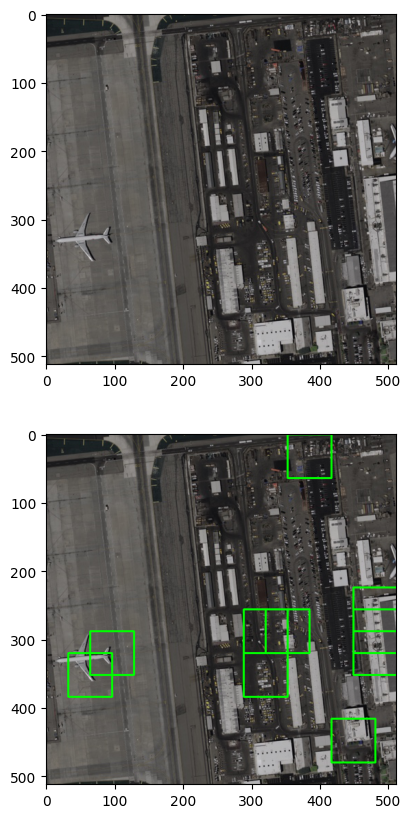

In [58]:
k = np.random.randint(eval_tiles.shape[0])
image = np.copy(eval_tiles[k])
results = apply_model_on_large_image(image, MODEL)
plot_results_on_image(image, results)

## What's next ?

Well...

Are you satisfied with the behaviour of your model ?  Are there a lot of false positives ?

If so, you can go back to the previous notebooks to tune your model and re-apply it.

If you're out of your depth on how to improve your model... think about it ;)  You should be able to find news ideas because really, those problems have no end

Welcome to the life of a DL engineer !